In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [ ]:
from SynTemp.SynRule.rule_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [ ]:
its_graph_rules_cluster[0]

In [ ]:
from SynTemp.SynUtils.utils import stratified_random_sample
import pandas as pd
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=23)
pd.DataFrame(sampled_data)['Reaction Type'].value_counts()

In [ ]:
single = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Single Cyclic']
complex = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Complex Cyclic']
neither = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'None']
acyclic = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Acyclic']

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer()
vis.graph_vis(complex[4], show_node_labels=True)

In [ ]:
from SynTemp.SynRule.rule_decompose import GraphRuleDecompose

In [ ]:
from copy import deepcopy
complex_graph = complex[11]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GraphRuleDecompose.bfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
    GraphRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/golden/golden_dataset.csv')
df.head(2)

from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
pd.DataFrame(data).info()

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator 
for key, value in enumerate(data):
    try:
        AMMValidator.smiles_check(data[key]['ground_truth'], data[key]['rdt'])
    except:
        print(key)

In [ ]:
data[366]['rdt']

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='Ground turth', 
                                       mapped_cols=['RXNMapper', 'GraphMapper', 'LocalMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

In [ ]:
pd.DataFrame(recon).to_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')

In [ ]:
import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
import pandas as pd

In [ ]:
ecoli = pd.read_csv('./Data/ecoli/ecoli.smiles', header=None)
ecoli.rename({0:'ground_truth'}, axis=1, inplace=True)
ecoli['R-id'] = range(1, len(ecoli) + 1)

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
ok = []
bug = []
for key, value in enumerate(ecoli['ground_truth']):
    try:
        rdChemReactions.ReactionFromSmarts(value)
        ok.append(key)
    except:
        bug.append(key)

In [ ]:
a,b,c =ecoli['ground_truth'][bug[0]].split('>>')

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(a)

In [ ]:
Chem.MolFromSmiles(b)

In [ ]:
Chem.MolFromSmiles(c)

In [ ]:
print(ecoli.iloc[bug,:]['ground_truth'])

In [ ]:
ecoli = ecoli.iloc[ok, :]
ecoli.reset_index(drop=True, inplace=True)
#ecoli = ecoli.to_dict('records')

In [ ]:
from rdkit import Chem
from typing import List, Optional
import re

def remove_atom_mapping(smiles: str) -> str:
    """
    Removes atom mapping numbers and simplifies atomic notation in a SMILES string.
    
    This function processes a SMILES string to:
    1. Remove any atom mapping numbers denoted by ':' followed by one or more digits.
    2. Simplify the atomic notation by removing square brackets around atoms that do not need them.
    
    Parameters:
    - smiles (str): The SMILES string to be processed.
    
    Returns:
    - str: The processed SMILES string with atom mappings removed and simplified atomic notations.
    """
    # Remove atom mapping numbers
    pattern = re.compile(r":\d+")
    smiles = pattern.sub("", smiles)
    # Simplify atomic notation by removing unnecessary square brackets
    pattern = re.compile(r"\[(?P<atom>(B|C|N|O|P|S|F|Cl|Br|I){1,2})(?:H\d?)?\]")
    smiles = pattern.sub(r"\g<atom>", smiles)
    return smiles

def mol_from_smiles(smiles: str) -> Optional[Chem.Mol]:
    """
    Converts a SMILES string to an RDKit Mol object, with error handling for invalid strings.
    
    Parameters:
    - smiles (str): The SMILES string to be converted.
    
    Returns:
    - Chem.Mol: An RDKit Mol object created from the given SMILES string. None if conversion fails.
    
    Raises:
    - ValueError: If the SMILES string is invalid and cannot be converted to a Mol object.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    return mol

def filter_valid_molecules(smiles_list: List[str]) -> List[Chem.Mol]:
    """
    Filters a list of SMILES strings, converting them to RDKit Mol objects, while ignoring invalid or empty molecules.
    
    Parameters:
    - smiles_list (List[str]): A list of SMILES strings to be processed.
    
    Returns:
    - List[Chem.Mol]: A list of RDKit Mol objects derived from valid, non-empty SMILES strings in the input list.
    """
    valid_molecules = []
    for smiles in smiles_list:
        try:
            mol = mol_from_smiles(smiles)
            if mol.GetNumAtoms() > 0:
                valid_molecules.append(mol)
        except ValueError:
            continue
    return valid_molecules

def standardize_rsmi(rsmi: str) -> str:
    """
    Standardizes a reaction SMILES (rSMI) by ensuring that all reactants and products are valid molecules with atoms.
    
    The function splits the reaction into reactants and products, filters and validates them, and then
    assembles them back into a standardized reaction SMILES string.
    
    Parameters:
    - rsmi (str): The reaction SMILES string to be standardized.
    
    Returns:
    - str: The standardized reaction SMILES string with valid and non-empty reactants and products.
    """
    reactants, products = rsmi.split('>>')
    reactant_molecules = filter_valid_molecules(reactants.split('.'))
    product_molecules = filter_valid_molecules(products.split('.'))

    # Convert molecules back to SMILES and assemble the standardized reaction SMILES string
    standardized_reactants = '.'.join(Chem.MolToSmiles(mol) for mol in reactant_molecules)
    standardized_products = '.'.join(Chem.MolToSmiles(mol) for mol in product_molecules)

    return f"{standardized_reactants}>>{standardized_products}"


ecoli['ground_truth'] = ecoli['ground_truth'].apply(standardize_rsmi)


In [ ]:
import re
def remove_atom_mapping(smiles: str) -> str:
    pattern = re.compile(r":\d+")
    smiles = pattern.sub("", smiles)
    pattern = re.compile(r"\[(?P<atom>(B|C|N|O|P|S|F|Cl|Br|I){1,2})(?:H\d?)?\]")
    smiles = pattern.sub(r"\g<atom>", smiles)
    return smiles
ecoli['reactions'] = ecoli['ground_truth'].apply(remove_atom_mapping)
ecoli = ecoli.to_dict('records')

In [ ]:
from SynTemp.SynUtils.utils import save_database
save_database(ecoli, './Data/ecoli/ecoli_reactions.json.gz')

In [ ]:
Chem.MolFromSmiles(ecoli.loc[189, 'reactions'])

In [ ]:
bug

In [ ]:

rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])O.[N:3]>>[C:1](=[O:2])[N:3]')
reacts = (Chem.MolFromSmiles('C(=O)O'),Chem.MolFromSmiles('CNC'))
products = rxn.RunReactants(reacts)

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
recon[0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/ecoli/ecoli_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt', 'ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test = pd.DataFrame(recon).drop(['reactions'], axis =1)
test['local_mapper_result'] = pd.DataFrame(results).loc[2, 'results']
test['rxn_mapper_result'] = pd.DataFrame(results).loc[0, 'results']
test['graphormer_result'] = pd.DataFrame(results).loc[1, 'results']
test['rdt_result'] = pd.DataFrame(results).loc[3, 'results']

In [ ]:
test.to_csv('./Data/ecoli/ecoli_aam_reactions.csv')

In [ ]:
pd.DataFrame(results)

In [ ]:
pd.DataFrame(results).loc[2, 'results']

In [ ]:
test_2 = test[['local_mapper_result', 'rxn_mapper_result', 'graphormer_result', 'rdt_result']]

In [ ]:
def ensemble_results(df, threshold):
    # Calculate the sum of True values in each row
    true_counts = df.sum(axis=1)
    # Apply the threshold to determine the final result
    final_results = true_counts >= threshold
    return final_results

test_3 = ensemble_results(test_2, 2)

In [ ]:
test_3.sum()/273

In [ ]:
uspto_sample = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')

In [ ]:
uspto_sample['LocalMapper_correct'].sum()

In [ ]:
uspto_sample

# Bug

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/aam_benchmark/Golden_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/benchmark.csv')
df = pd.read_csv('./Data/aam_benchmark/NatComm_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')
df = pd.read_csv('./Data/ecoli/ecoli_aam_reactions.csv')
#df = pd.read_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')
df.head(1)

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=df, ground_truth_col='ground_truth', 
                                       mapped_cols=['ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test_0 = df[['ground_truth', 'R-id']]
test_0['results'] = results[0]['results']

In [ ]:
test_0_bug = test_0.loc[test_0['results']==False, :]

In [ ]:
rsmi = test_0_bug['ground_truth'][74]

In [ ]:
from SynTemp.SynITS.its_construction import ITSConstruction
from SynTemp.SynITS.its_extraction import ITSExtraction
reactants, products = rsmi.split('>>')
G, H = ITSExtraction.graph_from_smiles(reactants), ITSExtraction.graph_from_smiles(products)

In [ ]:
rsmi

In [ ]:
reactants

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(reactants)

In [ ]:
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()

In [ ]:
vis.visualize_reaction(test_0_bug.iloc[0]['ground_truth'])

In [ ]:
test_0_bug.iloc[0]['ground_truth']

In [ ]:
import pandas as pd


df = pd.read_csv('./Data/USPTO_50K/USPTO_50K.csv')
df.drop_duplicates(subset=['reactions'], inplace=True)
df['R-id'] = ['USPTO-' + str(i) for i in range(len(df))]
df.head(2)

# MOD

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
test = RuleExecutor.reaction_prediction(input_smiles=['C=C1C(=C)C2OC1C1=C2CC(C(C)=O)CC1'],
                                        rule_file_path='./Data/uspto/Rule/USPTO_50K_31.gml',
                                        prediction_type='backward', repeat_times=1, print_results=False)

test

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
test = RuleExecutor.reaction_database_prediction(database=database[:],  rule_file_path='./Data/uspto/Rule/',
                                         original_rsmi_col='reactions', prediction_type = 'backward', repeat_times=1)


In [ ]:
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

# Ranking

In [ ]:
from SynTemp.SynUtils.utils import load_database
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1, prior=True)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

In [ ]:
from SynTemp.SynRule.similarity_ranking import SimilarityRanking


processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['FCFP6'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 2, ignore_stero=True))

In [ ]:
processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['RDK7'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 5, ignore_stero=True))

## Visualize

In [ ]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/uspto_sample/uspto_sample_aam_reactions.json.gz')

In [ ]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_and_compare_reactions(data[0], num_cols=3)

In [ ]:
from SynTemp.SynVis.its_visualizer import ITSVisualizer
from IPython.display import Image
its_vis = ITSVisualizer(data[0]['rxn_mapper'])
display(Image(its_vis.draw_product_with_modified_bonds()))

In [ ]:
import pandas as pd

df = pd.read_csv('./Data/USPTO_50K/USPTO_50K.csv')

In [ ]:
df['reactions'][0]

In [ ]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_reaction(df['reactions'][2], show_atom_map=False)

In [ ]:
df['reactions'][2]

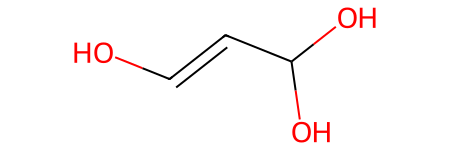

In [145]:
Chem.MolFromSmiles('C(O)(O)C=CO')

In [203]:
from fgutils import FGQuery
smiles = "C(O)(O)C=CO" # acetylsalicylic acid
query = FGQuery(use_smiles=True) # use_smiles requires rdkit to be installed
query.get(smiles)

[('hemiketal', [0, 1, 2]), ('enol', [3, 4, 5])]

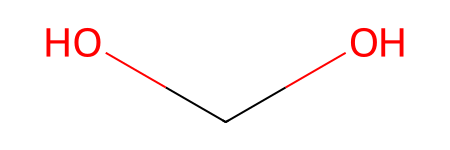

In [165]:
Chem.MolFromSmiles('C(O)(O)')

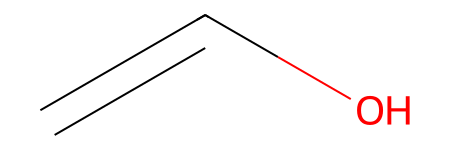

In [176]:
Chem.MolFromSmiles('C=CO')

In [189]:
for i in [0, 1, 2]:
    print(i)

0
1
2


In [200]:


enol("C=C(-O)C", [0, 1, 2])

'CC(C)=O'

In [206]:

smiles = "C(O)(O)C=CO" # acetylsalicylic acid
query = FGQuery(use_smiles=True) # use_smiles requires rdkit to be installed
fg = query.get(smiles)


In [210]:
if 'hemiketal' in fg[0]:
    print('hemiketal')

hemiketal


In [213]:
fg[0][1]

[0, 1, 2]

In [ ]:
Chem.MolFromSmiles()

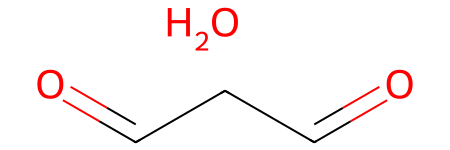

In [217]:
smiles = "C(O)(O)C=CO"
standardize = MoleculeStandardizer(smiles)
new_smiles = standardize.fit()
Chem.MolFromSmiles(new_smiles)

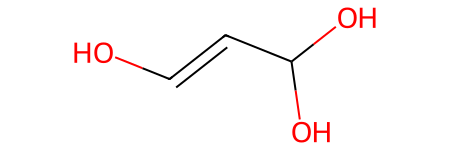

In [219]:
Chem.MolFromSmiles(smiles)

In [186]:
mol = Chem.MolFromSmiles("C=CO")
mol.GetAtomWithIdx(2).GetSymbol()

'O'

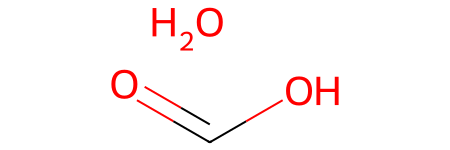

In [174]:
from rdkit import Chem
from rdkit.Chem import Draw

def hemiketal(smiles, atom_indices):
    # Load the molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    # Create a editable molecule object
    emol = Chem.EditableMol(mol)
    
    # Extract indices for C, O1, O2; assume the order might not be [C, O1, O2]
    c_idx, o1_idx, o2_idx = None, None, None
    for i in atom_indices:
        atom_symbol = mol.GetAtomWithIdx(i).GetSymbol()
        if atom_symbol == 'C':
            c_idx = i
        elif atom_symbol == 'O':
            if o1_idx is None:
                o1_idx = i  # Assume the first oxygen encountered is O1
            else:
                o2_idx = i  # The next oxygen is O2

    if None in [c_idx, o1_idx, o2_idx]:
        return "Invalid atom indices provided. Please check the input."

    # Remove the double bond between C and O1 (if exists)
    # It is safe to call RemoveBond in a try-except block to avoid errors if the bond does not exist
    try:
        emol.RemoveBond(c_idx, o1_idx)
        emol.RemoveBond(c_idx, o2_idx)
    except:
        pass
    
    # Add double bonds to oxygen 
    emol.AddBond(c_idx, o1_idx, order=Chem.rdchem.BondType.DOUBLE)
    # Create the new molecule
    new_mol = emol.GetMol()
    
    # Sanitize the molecule (important step to ensure the molecule is chemically valid)
    Chem.SanitizeMol(new_mol)
    
    # Return the SMILES of the new molecule
    return Chem.MolToSmiles(new_mol)

smiles_input = "C(O)(O)(O)"  # Example ketone
atom_indices = [0,1,2]  # Assuming indices [C, O, new O] for demonstration
new_smiles = hemiketal(smiles_input, atom_indices)
Chem.MolFromSmiles(new_smiles)


In [202]:
from rdkit import Chem
from typing import List, Union

def standardize_hemiketal(smiles: str, atom_indices: List[int]) -> str:
    """
    Modifies a ketone molecule (represented by a SMILES string) to its hemiketal form
    based on specified atom indices for carbon and two oxygens.

    Args:
    smiles (str): SMILES representation of the original molecule.
    atom_indices (List[int]): Indices of the carbon and two oxygen atoms involved in the transformation.
                              The order of indices does not need to be [C, O1, O2].

    Returns:
    str: SMILES string of the modified molecule if successful. If the indices are invalid or an error occurs,
         a string message indicating the error is returned.

    Example:
    >>> standardize_hemiketal("C(O)(O)C", [1, 2, 0])
    'C(=O)C'

    Raises:
    Exception: If bond modifications or molecule sanitization fail, it captures and returns the exception message.
    """
    # Load the molecule from SMILES and create an editable molecule object
    mol = Chem.MolFromSmiles(smiles)
    emol = Chem.EditableMol(mol)

    # Initialize indices
    c_idx, o1_idx, o2_idx = None, None, None
    # Determine the indices for carbon and oxygens
    for i in atom_indices:
        atom_symbol = mol.GetAtomWithIdx(i).GetSymbol()
        if atom_symbol == 'C':
            c_idx = i
        elif atom_symbol == 'O':
            if o1_idx is None:
                o1_idx = i  # Assume the first oxygen encountered is O1
            else:
                o2_idx = i  # The next oxygen is O2

    # Check if all indices are assigned
    if None in [c_idx, o1_idx, o2_idx]:
        return "Invalid atom indices provided. Please check the input."

    # Attempt to modify the molecule structure
    try:
        # Remove existing bonds if they exist
        emol.RemoveBond(c_idx, o1_idx)
        emol.RemoveBond(c_idx, o2_idx)
        # Add new bonds to form hemiketal
        emol.AddBond(c_idx, o1_idx, order=Chem.rdchem.BondType.DOUBLE)
    except Exception as e:
        return f"Error in modifying molecule: {str(e)}"

    # Generate the new molecule and sanitize it
    new_mol = emol.GetMol()
    try:
        Chem.SanitizeMol(new_mol)
    except Exception as e:
        return f"Error in sanitizing molecule: {str(e)}"

    # Return the new SMILES representation
    return Chem.MolToSmiles(new_mol)

standardize_hemiketal("C(O)(O)C", [1, 2, 0])


'CC=O.O'

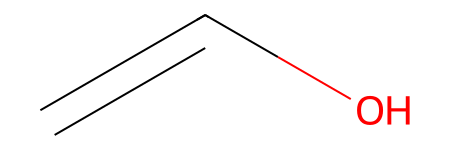

In [175]:
Chem.MolFromSmiles('C=CO')

In [ ]:
mol.GetAtomWithIdx

2023.09.5


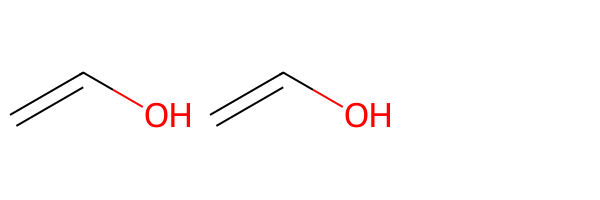

In [177]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import rdkit
print(rdkit.__version__)
m = Chem.MolFromSmiles('C=CO')
nrm = rdMolStandardize.Normalizer()
m2 = nrm.normalize(m)
Draw.MolsToGridImage([m,m2])

In [ ]:
# we provide the transformations in a string with one line per transformation.
# Lines starting with // are comments and are ignored. Each line contains the
# name of the transformation, a tab character, and then the reaction SMARTS for
# the transformation itself. It's also possible to skip the names; in that case
# just provide the reaction SMARTS (the tab is not needed)
tfs = '''
// this is from Deprotect.cpp:
remove_Boc\t[C;R0][C;R0]([C;R0])([O;R0][C;R0](=[O;R0])[NX3;H0,H1:1])C>>[N:1]
// this should go last, because later transformations will
// lose the alkali metal
disconnect_alkali_metals\t[Li,Na,K,Rb:1]-[A:2]>>([*+:1].[*-:2])
// test
kemiacetal\t
'''
# create the new Normalizer:
cps = rdMolStandardize.CleanupParameters()
nrm2 = rdMolStandardize.NormalizerFromData(tfs,cps)

# and apply it:
m2 = nrm2.normalize(m)
Draw.MolsToGridImage([m,m2])

In [161]:
mol = Chem.MolFromSmiles(smiles)
mol.GetAtomWithIdx(5).GetSymbol()

'O'

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles('Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1')

In [93]:
from SynTemp.SynUtils.utils import load_database

ecoli = pd.read_csv('./Ecoli_test.csv')

In [96]:
ecoli.iloc[0,1]

'[O:1]=[C:2]([O-:3])[C:4](=[O:5])[CH2:6][CH2:7][C:8](=[O:9])[O-:10].[O:11]=[C:12]([OH:13])[CH:14]([NH2:15])[CH2:16][CH:17]([CH3:18])[CH3:19]>>[O:1]=[C:2]([O-:3])[CH:4]([CH2:6][CH2:7][C:8](=[O:9])[O-:10])[NH3+:15]'

In [97]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()

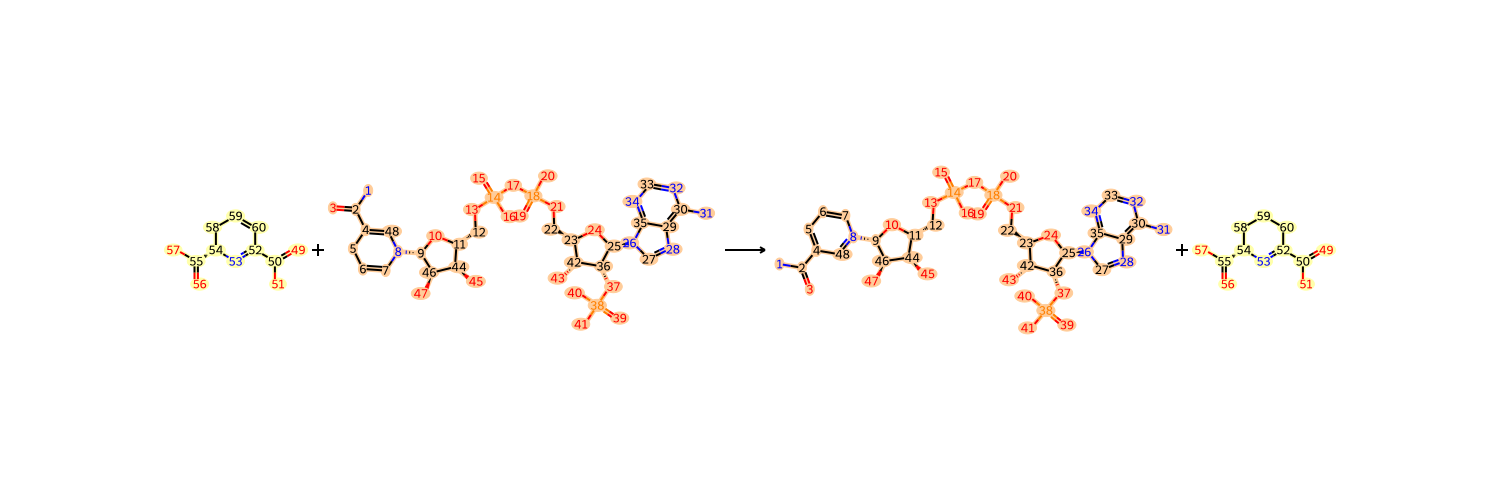

In [113]:
vis.visualize_reaction(ecoli.iloc[100,2],img_size=(1500,500), show_atom_map=True)

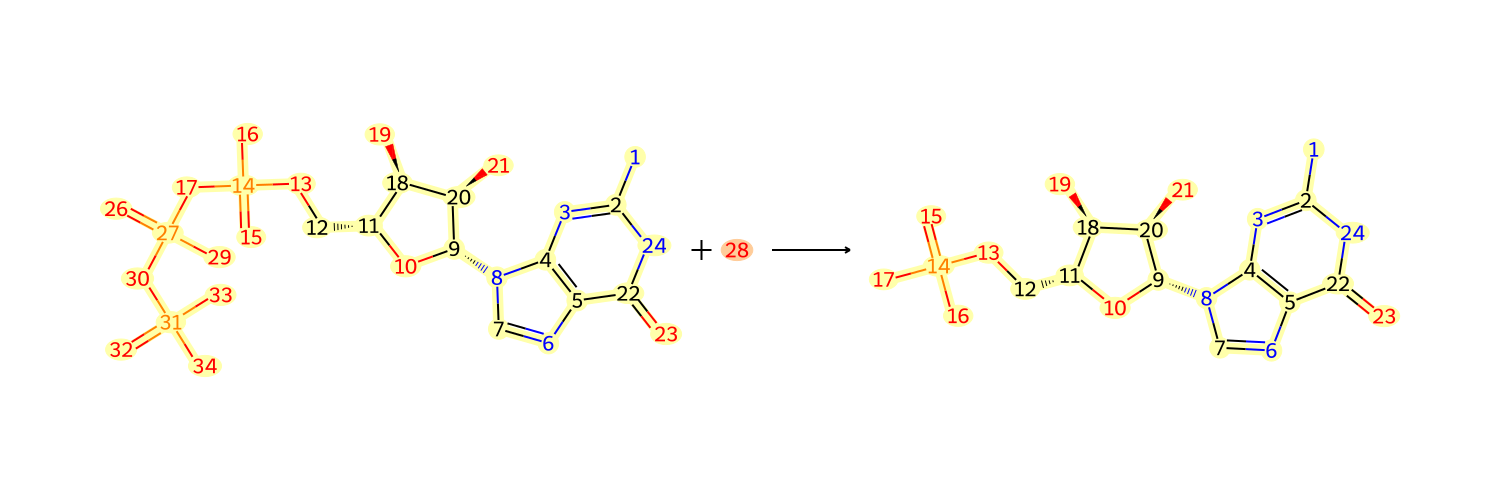

In [131]:
vis.visualize_reaction(ecoli.iloc[224,1],img_size=(1500,500), show_atom_map=True)

In [132]:
from synrbl import Balancer
balancer = Balancer()
sol =balancer.rebalance([ecoli.iloc[224,1]], output_dict=True)

/homes/biertank/tieu/miniconda3/envs/SynITSG/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/homes/biertank/tieu/miniconda3/envs/SynITSG/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


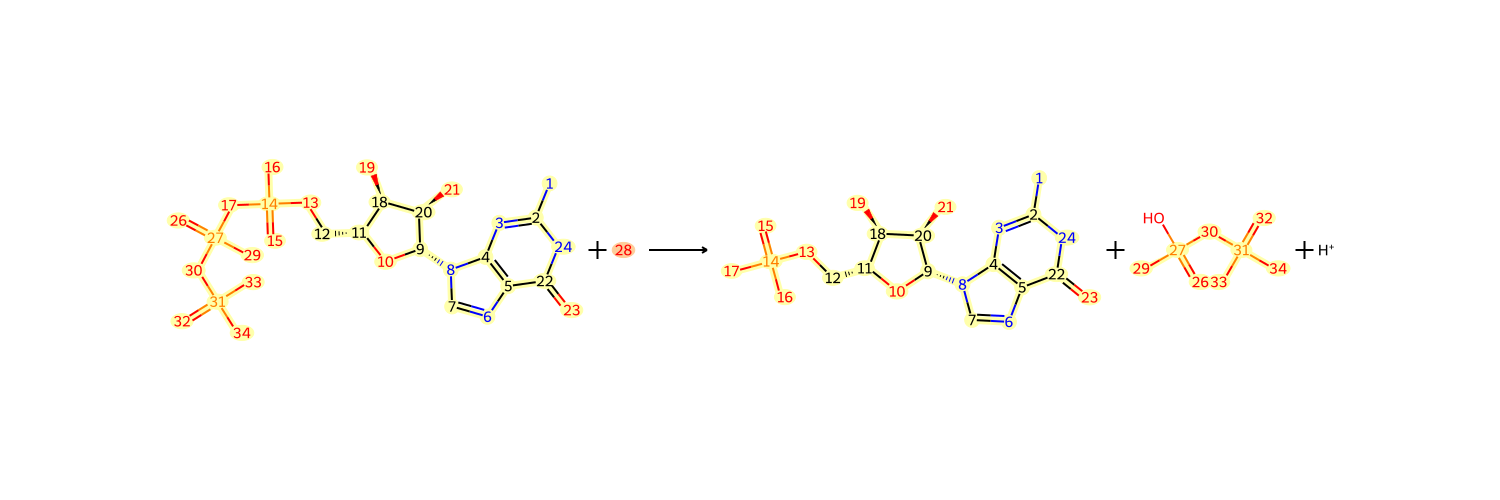

In [133]:
vis.visualize_reaction(sol[0]['reaction'],img_size=(1500,500), show_atom_map=True)

In [52]:
ecoli[111]['graphormer']

'[O-:26][P:24]([O-:27])(=[O:25])[O:23][P:20]([O-:22])(=[O:21])[O:19][P:16](=[O:17])([O:15][CH2:14][C@H:13]1[O:12][C@H:11]([C@@H:30]([C@@H:28]1[OH:29])[OH:31])[n:10]1[cH:9][n:8][c:7]2[c:2]([NH2:1])[n:3][cH:4][n:5][c:6]12)[O-:18].[OH:44][CH2:43][C@@H:42]1[C@@H:45]([OH:46])[C@H:47]([C@H:40]([n:39]2[cH:38][n:37][c:36]3[c:35]2[n:34][c:33]([NH2:32])[nH:51][c:49]3=[O:50])[O:41]1)[OH:48]>>[O-:18][P:16]([O-:19])(=[O:17])[O:44][CH2:43][C@@H:42]1[C@@H:45]([OH:46])[C@@H:47]([OH:48])[C@H:40]([n:39]2[cH:38][n:37][c:36]3[c:35]2[n:34][c:33]([nH:51][c:49]3=[O:50])[NH2:32])[O:41]1.[O-:26][P:24]([O-:27])([O:23][P:20]([O-:22])([O:15][CH2:14][C@@H:13]1[C@H:28]([C@H:30]([C@@H:11]([O:12]1)[n:10]1[cH:9][n:8][c:7]2[c:2]([NH2:1])[n:3][cH:4][n:5][c:6]12)[OH:31])[OH:29])=[O:21])=[O:25]'

In [53]:
test = '[O-:26][P:24]([O-:27])(=[O:25])[O:23][P:20]([O-:22])(=[O:21])[O:19][P:16](=[O:17])([O:15][CH2:14][C@H:13]1[O:12][C@H:11]([C@@H:30]([C@@H:28]1[OH:29])[OH:31])[n:10]1[cH:9][n:8][c:7]2[c:2]([NH2:1])[n:3][cH:4][n:5][c:6]12)[O-:18].[OH:44][CH2:43][C@@H:42]1[C@@H:45]([OH:46])[C@H:47]([C@H:40]([n:39]2[cH:38][n:37][c:36]3[c:35]2[n:34][c:33]([NH2:32])[nH:51][c:49]3=[O:50])[O:41]1)[OH:48]>>[O-:26][P:24]([O-:27])([O:23][P:20]([O-:22])([O:15][CH2:14][C@@H:13]1[C@H:28]([C@H:30]([C@@H:11]([O:12]1)[n:10]1[cH:9][n:8][c:7]2[c:2]([NH2:1])[n:3][cH:4][n:5][c:6]12)[OH:31])[OH:29])=[O:21])=[O:25]'

In [29]:
print(test)

N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)[c](=O)[nH]1>>N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)[c](=O)[nH]1.


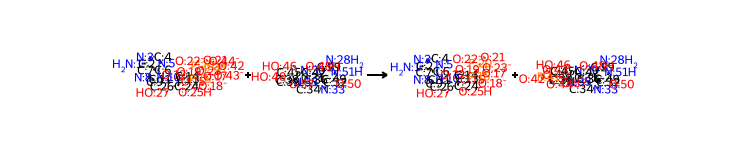

In [32]:
from rdkit.Chem import rdChemReactions
test = '[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O:19][P:20](=[O:21])([O-:22])[O:23][P:41](=[O:42])([O-:43])[O-:44])[C@@H:24]([OH:25])[C@H:26]1[OH:27].[NH2:28][c:29]1[n:30][c:31]2[c:32]([n:33][cH:34][n:35]2[C@@H:36]2[O:37][C@H:38]([CH2:39][OH:40])[C@@H:45]([OH:46])[C@H:47]2[OH:48])[c:49](=[O:50])[nH:51]1>>[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8][cH:9][n:10]2[C@@H:11]1[O:12][C@H:13]([CH2:14][O:15][P:16](=[O:17])([O-:18])[O:19][P:20](=[O:21])([O-:22])[O-:23])[C@@H:24]([OH:25])[C@H:26]1[OH:27].[NH2:28][c:29]1[n:30][c:31]2[c:32]([n:33][cH:34][n:35]2[C@@H:36]2[O:37][C@H:38]([CH2:39][O:40][P:41](=[O:42])([O-:43])[O-:44])[C@@H:45]([OH:46])[C@H:47]2[OH:48])[c:49](=[O:50])[nH:51]1'
rxn = rdChemReactions.ReactionFromSmarts(test, useSmiles=True)
rxn

In [138]:
import pandas  as pd
df = pd.read_csv('./test.csv')
df

,Unnamed: 0,reaction,solved,input_reaction,rules,solved_by,confidence
0,0,[O:1]=[C:2]([O-:3])[C:4](=[O:5])[CH2:6][CH2:7]...,False,[O:1]=[C:2]([O-:3])[C:4](=[O:5])[CH2:6][CH2:7]...,['default single bond'],NaN,NaN
1,1,[O:1]=[C:2]([O-:3])[C:4](=[O:5])[CH2:6][CH2:7]...,False,[O:1]=[C:2]([O-:3])[C:4](=[O:5])[CH2:6][CH2:7]...,NaN,NaN,NaN
2,2,[CH3:2][C@@H:3]([OH:1])[CH2:4][OH:5]>>[CH3:2][...,True,[CH3:2][C@@H:3]([OH:1])[CH2:4][OH:5]>>[CH3:2][...,NaN,rule-based,NaN
3,3,[O:1]=[C:2]([O-:3])[C@@H:4]([NH3+:5])[C@H:6]([...,True,[O:1]=[C:2]([O-:3])[C@@H:4]([NH3+:5])[C@H:6]([...,"['append O to C-C bond', 'default single bond']",mcs-based,0.214
4,4,[O:1]=[C:2]([O-:3])[C@@H:4]([NH3+:5])[C@H:6]([...,True,[O:1]=[C:2]([O-:3])[C@@H:4]([NH3+:5])[C@H:6]([...,"['append O to C-C bond', 'default single bond']",mcs-based,0.224
...,...,...,...,...,...,...,...
311,311,[O:1]=[P:2]([O-:3])([O-:4])[O:5][P:6](=[O:7])(...,False,[O:1]=[P:2]([O-:3])([O-:4])[O:5][P:6](=[O:7])(...,NaN,NaN,NaN
312,312,[O-:3][P:2]([O-:4])([O:5][CH2:6][C@@H:7]1[C@@H...,False,[O-:3][P:2]([O-:4])([O:5][CH2:6][C@@H:7]1[C@@H...,NaN,NaN,NaN
313,313,[O-:3][P:2]([O-:4])([O:5][CH2:6][C@@H:7]1[C@@H...,False,[O-:3][P:2]([O-:4])([O:5][CH2:6][C@@H:7]1[C@@H...,NaN,NaN,NaN
314,314,[O:7]=[CH:6][CH:4]([OH:5])[C:2](=[O:1])[O-:3]....,False,[O:7]=[CH:6][CH:4]([OH:5])[C:2](=[O:1])[O-:3]....,NaN,NaN,NaN


In [41]:
test = ecoli[111]['reactions']
react, prod = test.split('>>')

In [45]:
prod.split('.')

['N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O',
 'N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)[c](=O)[nH]1',
 '']

In [44]:
from rdkit import Chem

Chem.MolFromSmiles(prod)

[13:52:52] SMILES Parse Error: syntax error while parsing: N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)[c](=O)[nH]1.
[13:52:52] SMILES Parse Error: Failed parsing SMILES 'N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)[c](=O)[nH]1.' for input: 'N[c]1[n][cH][n][c]2[c]1[n][cH][n]2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.N[c]1[n][c]2[c]([n][cH][n]2[C@@H]2O[C@H](COP(=O)([O-])[O-])[C@@H](O)[C@H]2O)[c](=O)[nH]1.'
